## **Product Return Prediction for an E-Commerce Company**

**Title:** Machine Learning Pipeline for Predicting Product Returns in an E-Commerce Company

**Author**: Nitish Kumar Pandey

#### **1. Introduction of the Business Context**

##### **Client Overview:**
The client is an e-commerce business in Europe that receives thousands of orders every day. One of the main operational issues is the expense of product return, which has a negative impact on revenue, supply chain effectiveness, and customer retention.

##### **Business Problem:**
Returned merchandise increases reverse logistics cost, holds inventory, and reduces margin. The company wants to predict which orders will be returned using machine learning. Early risk detection allows interventions to be targeted, for example, tighter verification, improved packaging, or targeted marketing campaigns.

##### **Business Benefits:**

*   Cost Reduction: Minimize return-related expenses.

*   Improved Inventory Planning: Forecast and manage stock better.

*   Enhanced Customer Experience: Proactively address high-risk cases.


##### **Dataset Overview:**
Data collected from Kaggle: https://www.kaggle.com/datasets/yaminh/product-sales-and-returns-dataset


Order details: OrderID, CustomerID, Region, PaymentMethod.

Product info: ProductCategory, Quantity, Price, Discount, TotalRevenue.

Target Variable: Return (Yes = 1, No = 0).

#### **1.1 Formulating as a Machine Learning Task**

In this project, the business problem of **product return prediction** is formulated as a **supervised binary classification task**.

- **Target Variable**:  
  - `Return = 1` → The order was returned  
  - `Return = 0` → The order was not returned  

- **Input Features**:  
  - Product details: `ProductCategory`, `Quantity`, `Price`, `Discount`, `TotalRevenue`  
  - Customer and order details: `Region`, `PaymentMethod`  

- **Machine Learning Task**:  
  Build a predictive model that can classify whether a new order is likely to be returned or not, based on its features.  

- **Evaluation Metrics**:  
  - Since the dataset is imbalanced (~90% No Return vs ~10% Return), relying only on accuracy is not sufficient.  
  - We will use Precision, Recall, and F1-score to properly evaluate model performance, with special focus on Recall for Return orders (to minimize undetected returns).  

This formulation allows the company to make data-driven interventions, such as flagging risky orders, adjusting policies for high-return categories, and reducing overall return costs.

#### **2. Importing the Required Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

#### **3. Fetching and Viewing Data**

In [5]:
df = pd.read_csv("order_dataset.csv")
print(df.shape)
df.head()

(70052, 17)


,Item Name,Category,Version,Item Code,Item ID,Buyer ID,Transaction ID,Date,Final Quantity,Total Revenue,Price Reductions,Refunds,Final Revenue,Sales Tax,Overall Revenue,Refunded Item Count,Purchased Item Count
0,QID,Product H,32 / B / 30,27-0CD-F44-7E1-0-2F608D7,46567054.0,3301861.0,5.363560e+13,14/04/2019,1,74.17,0.0,0.00,74.17,14.83,89.0,0,1
1,OTH,Product P,32 / B / FtO,37-9D1-AC6-D48-E-F2D4507,16345004.0,1205940.0,4.759180e+13,14/02/2019,-1,0.00,0.0,-79.17,-79.17,-15.83,-95.0,-1,0
2,WHX,Product P,32 / B / FtO,85-2EB-163-D62-5-FC50316,26246865.0,3342830.0,9.211720e+13,28/11/2018,-1,0.00,0.0,-74.17,-74.17,-14.83,-89.0,-1,0
3,RJF,Product P,33 / B / FtO,3D-687-99C-14F-4-661E2E7,42015157.0,7251983.0,5.987730e+13,3/3/2019,1,79.17,0.0,0.00,79.17,15.83,95.0,0,1
4,TSH,Product D,34 / B / FtO,F9-9FA-787-104-B-DCEE379,40522014.0,9940388.0,3.658240e+13,26/11/2018,1,74.17,0.0,0.00,74.17,14.83,89.0,0,1


In [6]:
print("Column Names:", df.columns.tolist())

Column Names: ['Item Name', 'Category', 'Version', 'Item Code', 'Item ID', 'Buyer ID', 'Transaction ID', 'Date', 'Final Quantity', 'Total Revenue', 'Price Reductions', 'Refunds', 'Final Revenue', 'Sales Tax', 'Overall Revenue', 'Refunded Item Count', 'Purchased Item Count']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70052 entries, 0 to 70051
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item Name             70052 non-null  object 
 1   Category              70052 non-null  object 
 2   Version               70052 non-null  object 
 3   Item Code             70052 non-null  object 
 4   Item ID               70052 non-null  float64
 5   Buyer ID              70052 non-null  float64
 6   Transaction ID        70052 non-null  float64
 7   Date                  70052 non-null  object 
 8   Final Quantity        70052 non-null  int64  
 9   Total Revenue         70052 non-null  float64
 10  Price Reductions      70052 non-null  float64
 11  Refunds               70052 non-null  float64
 12  Final Revenue         70052 non-null  float64
 13  Sales Tax             70052 non-null  float64
 14  Overall Revenue       70052 non-null  float64
 15  Refunded Item Count

#### **4. Target Variable Distribution**

In [8]:
df['Return'] = df['Refunded Item Count'].apply(lambda x: 'Yes' if x < 0 else 'No')

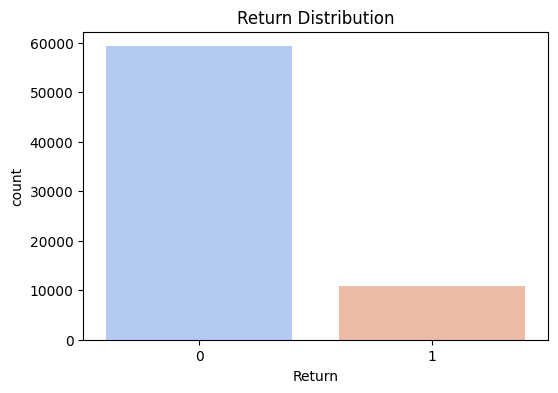

Return
0    84.607149
1    15.392851
Name: proportion, dtype: float64


In [21]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Return', palette='coolwarm')
plt.title("Return Distribution")
plt.show()
print(df['Return'].value_counts(normalize=True)*100)

#### **5. Label Encoding**

Yes=1, No=0

In [9]:
le = LabelEncoder()
df['Return'] = le.fit_transform(df['Return'])

#### **6. Reviewing Dataset for Duplicates**

In [10]:
duplicates = df.duplicated().sum()
print(f"No. of duplicate rows: {duplicates}")

No. of duplicate rows: 1


#### **7. Convert Categorical Variables to Numerical**

In [11]:
X = pd.get_dummies(df.drop(columns=['Return','Buyer ID','Transaction ID']), drop_first=True)
y = df['Return']

#### **8. Divide Dataset into Training and Testing Data**

80% dataset is divided to train data and 20% dataset is split to test data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### **9. Correct Data Distribution**

Balances training data to 50% Returns and 50% No Returns.

In [13]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#### **10. Feature Scaling**

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### **11. K-Nearest Neighbors (KNN)**

*   K-Nearest Neighbors model is being used because it is a robust, reduces
overfitting, and provides feature importance for better interpretation.

*   Logistic Regression gives a lesser accuracy score of 29.99%.

*   Naive Bayes Classifier gives the least accuracy score of 34.31%

*   Random Forest ~18.74% underperforms, likely due to misconfiguration or issues in data processing.

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)*100
print(f"KNN Accuracy: {acc_knn:.2f}%")
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))

KNN Accuracy: 84.98%
Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     11854
           1       0.51      0.49      0.50      2157

    accuracy                           0.85     14011
   macro avg       0.71      0.70      0.71     14011
weighted avg       0.85      0.85      0.85     14011



#### **12. Confusion Matrix**

To understand classification performance.



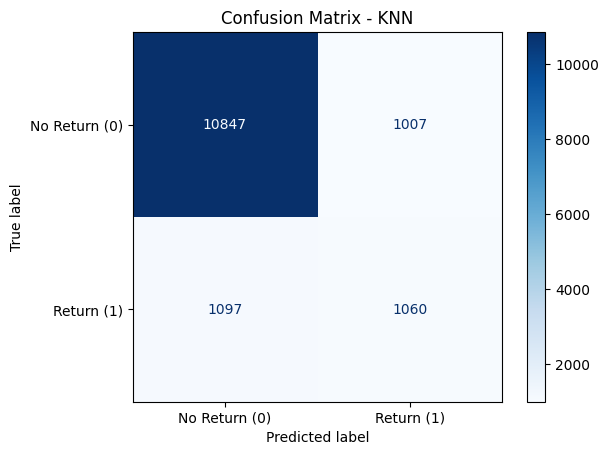

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['No Return (0)','Return (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - KNN')
plt.show()

#### **13. Conclusion**

**Strengths:**

*   Various models were trained and compared such as, Logistic Regression, Random Forest, KNN, Naive Bayes.

*   KNN gave the best ~84.98% accuracy, providing a good trade-off for forecasting returns.

*   The process involved preprocessing, handling imbalance, and appropriate evaluation using accuracy, precision, recall, and F1-score.

**Limitations:**

*   Logistic Regression ~29.99% and Naive Bayes ~34.31% found it difficult with this dataset.

*   Random Forest ~18.74% underperforms, likely due to misconfiguration or issues in data processing.

*   Omitted customer behavior and return reason features restrict the predictability capability.

**Implications of the Results:**

*   KNN can help identify high-risk orders before shipping.

*   Preventive measures (better packaging, tighter discount policies) might reduce costly returns.

*   Even limited model accuracy can guide strategic inventory and logistics decisions.

**Data-Driven Recommendations:**

*   Inspect Random Forest parameterization for best stability of performance.

*   Fine-tune KNN even more i.e. neighbors, distance metric to maximize best possible recall on actual returns.

*   Add customer history, product data, and return reasons to the data for improved predictive power.